In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("ps9.ipynb")

# PS9: Map and reduce with PySpark

In [2]:
import pyspark
spark = pyspark.sql.SparkSession.builder.\
    appName('ps9').\
    config('spark.ui.showConsoleProgress', False).\
    getOrCreate()
sc = spark.sparkContext

# Problem 1

This problem concerns counting words in text using `PySpark`.

In [3]:
simple_text_rdd = sc.textFile('simple.txt')
simple_text_rdd.collect()

['Raining cats and dogs',
 'Cats eat mice, mice eat cheese',
 'Mice and cats and dogs have fleas']

In [4]:
type(simple_text_rdd)

pyspark.rdd.RDD

## Part (a)
Write a function, called `count_words_per_line(text_rdd)`, which counts how many time each word appears in each line. The input `text_rdd` is a Resilient Distributed Dataset (`RDD`) of a text file, and the output will be another `RDD`.
- You should be able to perform this using solely `.map` operations on `text_rdd`.
- Your script should strip commas, colons, semicolons and periods, but leave other punctuation in place.
- Your script should ignore case.
- The output should be an `RDD` of `Counter` objects. When `.collect()` is called, the output should have the same length as the number of lines in the text.

In [5]:
from collections import Counter

In [6]:
import re
def count_words_per_line(text: pyspark.RDD):
    rm=r'[,:;.]'
    return text.map(lambda line: Counter(re.sub(rm,'',line).lower().strip().split(' ')))
    ...

In [7]:
count_words_per_line(simple_text_rdd).collect()

[Counter({'raining': 1, 'cats': 1, 'and': 1, 'dogs': 1}),
 Counter({'cats': 1, 'eat': 2, 'mice': 2, 'cheese': 1}),
 Counter({'mice': 1, 'and': 2, 'cats': 1, 'dogs': 1, 'have': 1, 'fleas': 1})]

In [8]:
grader.check("q1a")

q1a results: All test cases passed!

## Part (b)
Using your answer from part (a), write a function called `count_words` that returns a `Counter` of the words in the input text.
(Hint: use the `.reduce()` or `.fold()` method)

In [9]:
from operator import add
def count_words(text: pyspark.RDD):
    #return text.reduce(count_words_per_line)
    #r = sc.parallelize(count_words_per_line(text).collect())
    #return count_words_per_line(text).reduce(add) TOO SLOW! flatMap is faster
    rm=r'[,:;.]'
    return Counter(text.flatMap(lambda line: re.sub(rm,'',line).lower().split(' ')).collect())

In [10]:
count_words(simple_text_rdd)

Counter({'raining': 1,
         'cats': 3,
         'and': 3,
         'dogs': 2,
         'eat': 2,
         'mice': 3,
         'cheese': 1,
         'have': 1,
         'fleas': 1})

In [11]:
grader.check("q1b")

q1b results: All test cases passed!

## Part (c)

Write a function called `counter_to_rdd` that takes a Counter object and returns an RDD object such that each element is `(word, log(count))`, where `log()` is the natural logarithm, and sorted in descending order by `log(count)`.

In [12]:
import math
def counter_to_rdd(word_count):
    log_words = sc.parallelize(word_count.most_common()).map(lambda tup: (tup[0],math.log(tup[1])))
    return log_words

In [13]:
darwin_rdd = sc.textFile('darwin.txt')
darwin_rdd.first()

'The Project Gutenberg eBook of On the Origin of Species, by Charles Darwin'

In [14]:
darwin_word_count = count_words(darwin_rdd)
counter_to_rdd(darwin_word_count)

PythonRDD[11] at RDD at PythonRDD.scala:53

In [15]:
grader.check("q1c")

q1c results: All test cases passed!

<!-- BEGIN QUESTION -->

## Part (d)

Collect the output of the sorted log word counts and plot it using `matplotlib`.

Zipf’s law
states, roughly, that if one plots word frequency against frequency rank
(i.e., most frequent word, second most frequent word, etc.), the resulting line is (approximately) linear on a log-log scale. Using the information in darwin word counts.txt,
make a plot of word frequency as a function of word rank on a log-log scale for all
words in the file
`darwin.txt` 

How “Zipfian” does the resulting plot look? Write an answer in the box below. (It suffices for you to state whether or
not your plot looks approximately like a line)

The Zipfian looks like a declining line.

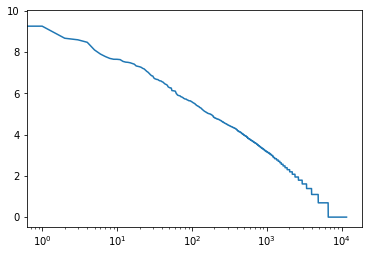

In [565]:
import numpy as np
from matplotlib import pyplot as plt

#order = a.argsort()
#ranks = order.argsort()
#a = np.vstack((a, ranks))
#ranks = np.arange(1,len(a)+1)
#a = np.vstack((a, ranks))
#a[1] = np.log(a[1])

a = np.array(counter_to_rdd(darwin_word_count).collect())
a = a[:,1].astype('float')

plt.plot(a)
plt.xscale("log")
plt.show()

<!-- END QUESTION -->

# Problem 2
The performance gains from PySpark come from using its SQL-like syntax on tabular data.

## Part (a)
Write a function called `read_population_df` that reads in `populations_small.txt` as a PySpark DataFrame. The result should have two columns labelled `id` and `value`. 

Note: `id` should be `LongType` and `value` should be `DoubleType`.

In [17]:
from pyspark.sql import types as T
from pyspark.sql import functions as F

In [18]:
def get_csv_schema(*args):
    return T.StructType([
        T.StructField(*arg)
        for arg in args
    ])

In [119]:
def read_population_df(filename: str) -> pyspark.sql.DataFrame:
    # Read the file
    df = spark.read.text(filename)
    
    # all values are in value column we have to split
    split_col = pyspark.sql.functions.split(df.value, ' ')
    df = df.withColumn('id', split_col.getItem(0))
    df = df.withColumn('value', split_col.getItem(1))
    
    # cast data types
    df = df.withColumn('id', F.col('id').cast(T.LongType()))
    df = df.withColumn('value', F.col('value').cast(T.DoubleType()))
    
    return df

In [120]:
df = read_population_df('populations_small.txt')

df.printSchema()
df.show()

root
 |-- value: double (nullable = true)
 |-- id: long (nullable = true)

+-----+---+
|value| id|
+-----+---+
|  2.0|  1|
|  3.0|  1|
|  1.0|  1|
|  0.0|  2|
|  2.0|  2|
| -2.0|  2|
| 10.0|  3|
| 10.0|  3|
+-----+---+



In [121]:
grader.check("q2a")

q2a results: All test cases passed!

## Part (b)

Write a function called `pop_mean_stddev` that takes a DataFrame with two columns, `id` and `value`,
and returns a data-frame where each row indicates mean and standard deviation of `value` for a particular value of `id`.

The resulting DataFrame should have three columns (`id`, `mean` and `stddev`) and should be sorted in ascending order by `id`.

In [466]:
def pop_mean_stddev(pop_df):
    newdf = pop_df.groupBy('id').agg(
    F.mean('value').alias('mean'),
    F.stddev_samp('value').alias('stddev')
    ).sort('id')
    
    return newdf

In [467]:
pop_mean_stddev(df).show()

+---+----+------+
| id|mean|stddev|
+---+----+------+
|  1| 2.0|   1.0|
|  2| 0.0|   2.0|
|  3|10.0|   0.0|
+---+----+------+



In [468]:
grader.check("q2b")

q2b results: All test cases passed!

# Problem 3

Recall the `fb.txt.gz` text file. You are given a PySpark Dataframe `fb_df` with one column called "value", which is a string. The first number is the user id, and the following number are their friends.

In [218]:
import pyspark.sql.functions as F
fb_df = spark.read.text("fb.txt.gz")
fb_df.take(5)

[Row(value='0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 27

## Part (a)

Write a function called parse_friends which transforms `fb_df` into a PySpark dataframe with two columns:
 - `id`: String indicating the friend
 - `friends`: An array column where each entry is the friends of `id` whose ids come after `id`.
 

```
>>> friends = parse_friends(fb_df)
>>> friends.take(2)
[Row(id='0', friends=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347']),
 Row(id='1', friends=['48', '53', '54', '73', '88', '92', '119', '126', '133', '194', '236', '280', '299', '315', '322', '346'])]
 ```
 `

In [606]:
def parse_friends(fb_df):
    df = fb_df.selectExpr("split(value, ' ') as value")
    df=df.withColumn('id', F.expr("slice(value, 1, 1)[0]"))
    df=df.withColumn('friends', F.expr("slice(value, 2, size(value))"))
    df = df.drop('value')
    return df

In [607]:
parse_friends(fb_df).show()

+---+--------------------+
| id|             friends|
+---+--------------------+
|  0|[1, 2, 3, 4, 5, 6...|
|  1|[48, 53, 54, 73, ...|
|  2|[20, 115, 116, 14...|
|  3|[9, 25, 26, 67, 7...|
|  4|[78, 152, 181, 19...|
|  5|[87, 122, 156, 15...|
|  6|[89, 95, 147, 219...|
|  7|[22, 31, 38, 65, ...|
|  8|[91, 110, 193, 20...|
|  9|[21, 25, 26, 30, ...|
| 10|[67, 142, 169, 20...|
| 13|[21, 26, 56, 59, ...|
| 14|[20, 28, 41, 115,...|
| 16|[29, 82, 118, 172...|
| 17|[19, 41, 111, 115...|
| 19|[41, 89, 112, 115...|
| 20|[41, 44, 111, 115...|
| 21|[25, 26, 31, 39, ...|
| 22|[87, 158, 168, 18...|
| 23|[51, 61, 83, 99, ...|
+---+--------------------+
only showing top 20 rows



In [608]:
grader.check("q3a")

q3a results: All test cases passed!

## Part (b)

Write a function called `get_friend_pairs(fb_df)` which finds all pairs of friends in `fb_df`.

In [638]:
def get_friend_pairs(fb_df):
    spark_df = parse_friends(fb_df)
    df = spark_df.select((spark_df.id).alias('friend1'),(F.explode(spark_df.friends)).alias('friend2'))
    return df

In [639]:
get_friend_pairs(fb_df).show()

+-------+-------+
|friend1|friend2|
+-------+-------+
|      0|      1|
|      0|      2|
|      0|      3|
|      0|      4|
|      0|      5|
|      0|      6|
|      0|      7|
|      0|      8|
|      0|      9|
|      0|     10|
|      0|     11|
|      0|     12|
|      0|     13|
|      0|     14|
|      0|     15|
|      0|     16|
|      0|     17|
|      0|     18|
|      0|     19|
|      0|     20|
+-------+-------+
only showing top 20 rows



In [611]:
grader.check("q3b")

q3b results: All test cases passed!

## Part (c)
Write a function called `find_triangles(fb_df)` which finds the number of triangles in `fb_df`.

```
>>> find_triangles(fb_df).take(6)
[Row(friend1='0', friend2='1', friend3='48'),
 Row(friend1='0', friend2='1', friend3='53'),
 Row(friend1='0', friend2='1', friend3='54'),
 Row(friend1='0', friend2='1', friend3='73'),
 Row(friend1='0', friend2='1', friend3='88'),
 Row(friend1='0', friend2='1', friend3='92')]
```

In [727]:
def find_triangles(fb_df):
    three_a = parse_friends(fb_df)
    three_b = get_friend_pairs(fb_df)

    # Merge the dataframes, first on friend1, then on friend2
    merged_df = three_b.join(three_a, (three_b.friend2 == three_a.id)) #& (three_b.friend2 == three_a.id) , try id on friend2
    merged_df = merged_df.withColumnRenamed("friends", "friends_2")
    merged_df = merged_df.withColumnRenamed("id", "id_")
    merged_df = merged_df.join(three_a, (merged_df.friend1 == three_a.id))
    
    # Get common_friends for 
    common_friends = merged_df.select(merged_df.friend1,merged_df.friend2,F.array_intersect(merged_df.friends_2, merged_df.friends).alias('common_friends'))

    explode = common_friends.select(common_friends.friend1,common_friends.friend2,(F.explode(common_friends.common_friends)).alias('friend3'))
    return explode
    ...

In [728]:
find_triangles(fb_df).show()

+-------+-------+-------+
|friend1|friend2|friend3|
+-------+-------+-------+
|      0|      1|     48|
|      0|      1|     53|
|      0|      1|     54|
|      0|      1|     73|
|      0|      1|     88|
|      0|      1|     92|
|      0|      1|    119|
|      0|      1|    126|
|      0|      1|    133|
|      0|      1|    194|
|      0|      1|    236|
|      0|      1|    280|
|      0|      1|    299|
|      0|      1|    315|
|      0|      1|    322|
|      0|      1|    346|
|      0|      2|     20|
|      0|      2|    115|
|      0|      2|    116|
|      0|      2|    149|
+-------+-------+-------+
only showing top 20 rows



In [729]:
grader.check("q3c")

q3c results: All test cases passed!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Upload this .zip file to Gradescope for grading.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)